# Final Code

## Import statements

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing All the necessary Libraries

In [18]:
# -*- coding: utf-8 -*from keras.models import Sequential
import numpy as np
from numpy.random import RandomState
import torch
import scipy.io as sio
import time
from matplotlib import pyplot as plt
# from matlab import eng

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import random_split
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F

## Funtions used in different classes.

Create `ComputeVonMisesStress_all` to return all three components of 2D-stress along with Von-Mises Stress.

In [3]:
#%% S11/S22/S12: 5000xN, S_all=[S11; S22; S12]
def ComputeVonMisesStress_all(S_all):

    S11_all=S_all[:, 0:5000]
    S22_all=S_all[:, 5000:10000]
    S12_all=S_all[:, 10000:15000]
    VM_all = S11_all**2 + S22_all**2 - S11_all*S22_all +3*S12_all**2
    VM_all = torch.sqrt(VM_all)

    return S11_all, S22_all, S12_all, VM_all

Create `ComputeError` to calculate different types of error as mentioned in the research paper:
*    `MAE`:- Mean Absolute Error. 
*    `NMAE`:- Normalised mean Absolute Error
*    `AE`:- Absolute Error
*    `NAE`:- Normalised Absolute Error

In [4]:
def ComputeError(A, B):
    MAE=np.zeros(A.shape[1])
    NMAE=np.zeros(A.shape[1])
    AE=np.zeros(A.shape[1])
    NAE=np.zeros(A.shape[1])
    for n in range(0, A.shape[1]):
        a=A[:,n]
        b=B[:,n]
        c=torch.absolute(a-b)
        a_abs=torch.absolute(a)
        b_abs=torch.absolute(b)
        a_max=torch.max(a_abs)
        b_max=torch.max(b_abs)
        MAE[n]=torch.mean(c)
        NMAE[n]=MAE[n]/a_max
        AE[n]=torch.absolute(a_max-b_max)
        NAE[n]=AE[n]/a_max
    return MAE, NMAE, AE, NAE


## Exporting variable and formatting it in executable format 

Exporting the `ShapeData.mat` and `StressData.mat`, which are the inputs and labels respectively.

In [7]:
# importing data
ShapeDataFile = '/content/drive/MyDrive/Colab Notebooks/Project Data/ShapeData.mat'
StressDataFile = '/content/drive/MyDrive/Colab Notebooks/Project Data/StressData.mat'
MatData_shape=sio.loadmat(ShapeDataFile)
MatData_stress=sio.loadmat(StressDataFile)

Converting the matlab files into the feasible type to use it in `NonLinearMapping` and `AllInOne` classes.
*    `NonLinearMapping`: This class implements a simple non-Linear neural network with 2 hidden layers with 128 neurons in each. This is really time taking process.
*    `AllInOne`: This class implements the algorithm mentioned in the research paper. It does encoding of shape, non-linear mapping of encoded shape to stress and decoding and encoding of stress.

In [8]:
stress_np = np.array(MatData_stress['StressData'])
shape_np = np.array(MatData_shape['ShapeData'])
# arraning the stress data for y
stress_S11 = stress_np[0,:,:]
stress_S22 = stress_np[1,:,:]
stress_S12 = stress_np[3,:,:]
stress_all = np.concatenate([stress_S11,stress_S22,stress_S12], axis=0)

# preparing inputs for process without encoding and decoding
# these will be used by class NonLinearMapping
shape_tensor_NNM = torch.from_numpy(shape_np)
stress_tensor_NNM = torch.from_numpy(stress_all)
dataset = TensorDataset(shape_tensor_NNM.t().float(), stress_tensor_NNM.t().float())

# peparing inputs for process with encoding and decoding
# these will be used by class AllInOne
shape_tensor_AIO = torch.from_numpy(shape_np)
shape_tensor_AIO = shape_tensor_AIO.float()
stress_tensor_AIO = torch.from_numpy(stress_np)
stress_tensor_AIO = stress_tensor_AIO.float()

## Error calculating classes

The class `ErrorComputer_NMM` is class design for the class `NonLinearMapping` class to compute all the errors for validation as well as testing case. It has folowing three methods:
*    `__init__`: It is constructor of the class and initialize fields of the .
*    `compute`: It calculates all the above mentioned errors and apppend the result in the fields.
*    `print`: It prints the mean and standard deviation of all errors nicely in tabular format.

In [9]:
class ErrorComputer_NNM():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, train_loader, model):
        self.model = model
        self.train_loader = train_loader
        self.MAE_S11 = []
        self.NMAE_S11 = []
        self.AE_S11 = []
        self.NAE_S11 = []
        self.MAE_S22 = []
        self.NMAE_S22 = []
        self.AE_S22 = []
        self.NAE_S22 =  []
        self.MAE_S12 = []
        self.NMAE_S12 = []
        self.AE_S12 = []
        self.NAE_S12 = []
        self.MAE_VM = []
        self.NMAE_VM = []
        self.AE_VM = []
        self.NAE_VM = []
                
    def compute(self):
        """Yield a batch of data after moving it to device"""
        for batch in self.train_loader:
            shape, stress = batch
            pred_stress = self.model(shape)
            [pred_S11, pred_S22, pred_S12, pred_VM] = ComputeVonMisesStress_all(pred_stress)
            [S11, S22, S12, VM] = ComputeVonMisesStress_all(stress)
            [MAE_S11, NMAE_S11, AE_S11, NAE_S11] = ComputeError(pred_S11, S11)
            [MAE_S22, NMAE_S22, AE_S22, NAE_S22] = ComputeError(pred_S22, S22)
            [MAE_S12, NMAE_S12, AE_S12, NAE_S12] = ComputeError(pred_S12, S12)
            [MAE_VM, NMAE_VM, AE_VM, NAE_VM] = ComputeError(pred_VM, VM)
            self.MAE_S11.append(MAE_S11)
            self.NMAE_S11.append(NMAE_S11)
            self.AE_S11.append(AE_S11)
            self.NAE_S11.append(NAE_S11)
            self.MAE_S22.append(MAE_S22)
            self.NMAE_S22.append(NMAE_S22)
            self.AE_S22.append(AE_S22)
            self.NAE_S22.append(NAE_S22)
            self.MAE_S12.append(MAE_S12)
            self.NMAE_S12.append(NMAE_S12)
            self.AE_S12.append(AE_S12)
            self.NAE_S12.append(NAE_S12)
            self.MAE_VM.append(MAE_VM)
            self.NMAE_VM.append(NMAE_VM)
            self.AE_VM.append(AE_VM)
            self.NAE_VM.append(NAE_VM)

    def print(self):
        print_MAE_mean = 'MAE mean\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print_MAE_std = 'MAE std\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print_NMAE_mean = 'NMAE mean\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print_NMAE_std = 'NMAE std\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print_AE_mean = 'AE mean\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print_AE_std = 'AE std\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print_NAE_mean = 'NAE mean\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print_NAE_std = 'NAE std\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print('Error\t\tS11\t\tS22\t\tS12\t\tVM')
        print('-------------------------------------------------------------------------')
        print(print_MAE_mean.format(np.mean(self.MAE_S11), np.mean(self.MAE_S22), np.mean(self.MAE_S12), np.mean(self.MAE_VM)))
        print(print_MAE_std.format(np.std(self.MAE_S11), np.std(self.MAE_S22), np.std(self.MAE_S12), np.std(self.MAE_VM)))
        print(print_NMAE_mean.format(np.mean(self.NMAE_S11), np.mean(self.NMAE_S22), np.mean(self.NMAE_S12), np.mean(self.NMAE_VM)))
        print(print_NMAE_std.format(np.std(self.NMAE_S11), np.std(self.NMAE_S22), np.std(self.NMAE_S12), np.std(self.NMAE_VM)))
        print(print_AE_mean.format(np.mean(self.AE_S11), np.mean(self.AE_S22), np.mean(self.AE_S12), np.mean(self.AE_VM)))
        print(print_AE_std.format(np.std(self.AE_S11), np.std(self.AE_S22), np.std(self.AE_S12), np.std(self.AE_VM)))
        print(print_NAE_mean.format(np.mean(self.NAE_S11), np.mean(self.NAE_S22), np.mean(self.NAE_S12), np.mean(self.NAE_VM)))
        print(print_NAE_std.format(np.std(self.NAE_S11), np.std(self.NAE_S22), np.std(self.NAE_S12), np.std(self.NAE_VM)))

The class `ErrorComputer_AIO` is class design for the class `AllInOne` class to compute all the errors for validation as well as testing case. It has folowing three methods:
*    `__init__`: It is constructor of the class and initialize fields of the .
*    `compute`: It calculates all the above mentioned errors and apppend the result in the fields.
*    `print`: It prints the mean and standard deviation of all errors nicely in tabular format.

In [10]:
class ErrorComputer_AIO():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, stress, pred_stress):
        self.stress = stress
        self.pred_stress = pred_stress
        self.MAE_S11 = []
        self.NMAE_S11 = []
        self.AE_S11 = []
        self.NAE_S11 = []
        self.MAE_S22 = []
        self.NMAE_S22 = []
        self.AE_S22 = []
        self.NAE_S22 =  []
        self.MAE_S12 = []
        self.NMAE_S12 = []
        self.AE_S12 = []
        self.NAE_S12 = []
        self.MAE_VM = []
        self.NMAE_VM = []
        self.AE_VM = []
        self.NAE_VM = []
                
    def compute(self):
        """Yield a batch of data after moving it to device"""
        [pred_S11, pred_S22, pred_S12, pred_VM] = ComputeVonMisesStress_all(self.pred_stress)
        [S11, S22, S12, VM] = ComputeVonMisesStress_all(self.stress)
        [self.MAE_S11, self.NMAE_S11, self.AE_S11, self.NAE_S11] = ComputeError(pred_S11, S11)
        [self.MAE_S22, self.NMAE_S22, self.AE_S22, self.NAE_S22] = ComputeError(pred_S22, S22)
        [self.MAE_S12, self.NMAE_S12, self.AE_S12, self.NAE_S12] = ComputeError(pred_S12, S12)
        [self.MAE_VM, self.NMAE_VM, self.AE_VM, self.NAE_VM] = ComputeError(pred_VM, VM)

    def print(self):
        print_MAE_mean = 'MAE mean\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print_MAE_std = 'MAE std\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print_NMAE_mean = 'NMAE mean\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print_NMAE_std = 'NMAE std\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print_AE_mean = 'AE mean\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print_AE_std = 'AE std\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print_NAE_mean = 'NAE mean\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print_NAE_std = 'NAE std\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}'
        print('Error\t\tS11\t\tS22\t\tS12\t\tVM')
        print('-------------------------------------------------------------------------')
        print(print_MAE_mean.format(np.mean(self.MAE_S11), np.mean(self.MAE_S22), np.mean(self.MAE_S12), np.mean(self.MAE_VM)))
        print(print_MAE_std.format(np.std(self.MAE_S11), np.std(self.MAE_S22), np.std(self.MAE_S12), np.std(self.MAE_VM)))
        print(print_NMAE_mean.format(np.mean(self.NMAE_S11), np.mean(self.NMAE_S22), np.mean(self.NMAE_S12), np.mean(self.NMAE_VM)))
        print(print_NMAE_std.format(np.std(self.NMAE_S11), np.std(self.NMAE_S22), np.std(self.NMAE_S12), np.std(self.NMAE_VM)))
        print(print_AE_mean.format(np.mean(self.AE_S11), np.mean(self.AE_S22), np.mean(self.AE_S12), np.mean(self.AE_VM)))
        print(print_AE_std.format(np.std(self.AE_S11), np.std(self.AE_S22), np.std(self.AE_S12), np.std(self.AE_VM)))
        print(print_NAE_mean.format(np.mean(self.NAE_S11), np.mean(self.NAE_S22), np.mean(self.NAE_S12), np.mean(self.NAE_VM)))
        print(print_NAE_std.format(np.std(self.NAE_S11), np.std(self.NAE_S22), np.std(self.NAE_S12), np.std(self.NAE_VM)))

## Model class for FE-ML approach

In [11]:
class NonLinearMapping(nn.Module):
    def __init__(self, train_loader):
        super().__init__()
        self.train_loader = train_loader
        self.loss_history_batch = []
        self.loss_history = []
        self.train_S11_error = []
        self.train_S22_error = []
        self.train_S12_error = []
        self.train_VM_error = []
        self.test_S11_error = []
        self.test_S22_error = []
        self.test_S12_error = []
        self.test_VM_error = []
        self.network = nn.Sequential(
            nn.Linear(15000, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 15000))
        
    def forward(self, xb):
        return self.network(xb)
    
    def training_step(self, train_batch):
        shape, stress = train_batch
        pred_stress = self(shape)                   
        loss = F.mse_loss(pred_stress, stress)
        return loss

    def train(self, epochs, opt_func=torch.optim.Adam):
        self.optimizer = opt_func(self.parameters())

        for epoch in range(epochs):

            self.loss_history_batch = []
            
            for batch in self.train_loader:
                self.batch = batch
                self.optimizer.step(self.closure)

            self.loss_history.append(sum(self.loss_history_batch)/len(self.loss_history_batch))
            self.epoch_end(epoch,epochs, print_every=250)

    def closure(self):
        self.optimizer.zero_grad()
        loss = self.training_step(self.batch)
        self.loss_history_batch.append(loss)
        loss.backward()
        return loss
    
    def validation_step(self): 
        trainError = ErrorComputer_NNM(self.train_loader, self)
        trainError.compute()
        trainError.print()
        self.train_S11_error = [trainError.MAE_S11,trainError.NMAE_S11,trainError.AE_S11,trainError.NAE_S11]
        self.train_S22_error = [trainError.MAE_S22,trainError.NMAE_S22,trainError.AE_S22,trainError.NAE_S22]
        self.train_S12_error = [trainError.MAE_S12,trainError.NMAE_S12,trainError.AE_S12,trainError.NAE_S12]
        self.train_VM_error = [trainError.MAE_VM,trainError.NMAE_VM,trainError.AE_VM,trainError.NAE_VM]
            
    def testing_step(self, test_loader):
        testError = ErrorComputer_NNM(test_loader, self)
        testError.compute()
        testError.print()
        self.test_S11_error = [testError.MAE_S11,testError.NMAE_S11,testError.AE_S11,testError.NAE_S11]
        self.test_S22_error = [testError.MAE_S22,testError.NMAE_S22,testError.AE_S22,testError.NAE_S22]
        self.test_S12_error = [testError.MAE_S12,testError.NMAE_S12,testError.AE_S12,testError.NAE_S12]
        self.test_VM_error = [testError.MAE_VM,testError.NMAE_VM,testError.AE_VM,testError.NAE_VM]

    def epoch_end(self, epoch, epochs, print_every=100):
        if epoch == 0 or epoch == (epochs - 1) or epoch % print_every == 0 or print_every == 'all':
            print("Epoch [{}/{}], train_loss: {:.4f}".format(epoch, epochs, self.loss_history[epoch]))

    


In [12]:
class AllInOne(nn.Module):

    def __init__(self, shape_train, stress_train):
        super().__init__()
        self.shape_train = shape_train
        self.stress_train = stress_train[[0,1,3],:,:]
        self.loss_history = []
        self.train_S11_error = []
        self.train_S22_error = []
        self.train_S12_error = []
        self.train_VM_error = []
        self.test_S11_error = []
        self.test_S22_error = []
        self.test_S12_error = []
        self.test_VM_error = []

    def shapeModelWeight(self):
        # Finding weight 
        meanShape = torch.mean(self.shape_train, axis=0)
        X = (self.shape_train - meanShape)/656**(.5)
        [U, S, V] = torch.svd(X)
        proj = U[:,:3]/S[:3]
        return proj.t()

    def stress_shape(self, stress):
        out =torch.zeros(stress.shape[0],15000)
        for i in range(stress.shape[0]):
            temp11 = stress[i,0,:,:].reshape(5000)
            temp22 = stress[i,1,:,:].reshape(5000)
            temp12 = stress[i,2,:,:].reshape(5000)
            out[i,:] = torch.cat([temp11,temp22,temp12])
        return out

    def stressModelWeight(self):
        # Finding the weight of first convo-NN network
        temp11 = self.stress_train[0]
        temp22 = self.stress_train[1]
        temp12 = self.stress_train[2]
        Sdata1 = torch.cat([temp11.reshape(200,-1),temp22.reshape(200,-1),temp12.reshape(200,-1)], axis=0)
        covar_mat = Sdata1@Sdata1.t()/Sdata1.shape[0]
        [U1, S1, V1] = torch.svd(covar_mat)
        W1 = U1[:,:256].reshape(-1,3,10,20)

        # creating the first layer of stress encoding NN
        # and initializing weights
        stressEncodingModel_layer1 = nn.Conv2d(3, 256, kernel_size=[10,20], stride=[10,20])
        with torch.no_grad():
            stressEncodingModel_layer1.weight = Parameter(W1)
        # evaluating the output of first layer
        SData = torch.zeros(self.stress_train.shape[-1], 3, 50, 100)
        for i in range(self.stress_train.shape[-1]):
            SData[i,0,:,:] += temp11[:,i].reshape(50,100)
            SData[i,1,:,:] += temp22[:,i].reshape(50,100)
            SData[i,2,:,:] += temp12[:,i].reshape(50,100)
        output = stressEncodingModel_layer1(SData)
        self.SData = SData

        # Finding the weight of second convo-NN network
        Sdata2 = output.reshape(-1,output.shape[0])
        covar_mat = Sdata2@Sdata2.T/Sdata2.shape[0]
        [U2, S2, V2] = torch.svd(covar_mat)
        W2 = U2[:,:64].reshape(-1,256,5,5)

        return W1, W2

    def createModel(self):
        self.nonLinearModel = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64))
        
        W1, W2 = self.stressModelWeight()
        self.stressDecodingModel = nn.Sequential(
            nn.ConvTranspose2d(64, 256, kernel_size=[5,5], stride=1),
            nn.ConvTranspose2d(256, 3, kernel_size=[10,20], stride=[10,20]))
        with torch.no_grad():
            self.stressDecodingModel[0].weight = Parameter(W2)
            self.stressDecodingModel[1].weight = Parameter(W1)

        self.stressEncodingModel = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=[10,20], stride=[10,20]),
            nn.Conv2d(256, 64, kernel_size=[5,5], stride=1),
            nn.Flatten())
        with torch.no_grad():
            self.stressEncodingModel[0].weight = Parameter(W1)
            self.stressEncodingModel[1].weight = Parameter(W2)

        proj = self.shapeModelWeight()
        self.shapeEncodingModel = nn.Linear(15000,3)
        with torch.no_grad():
            self.shapeEncodingModel.weight = Parameter(proj)
        
    def encodingDecoding(self):
        # performing shape encoding and stress encoding
        self.encodedShape = self.shapeEncodingModel(self.shape_train.t())
        self.encodedStress = self.stressEncodingModel(self.SData)

    def training_step(self):
        pred_stress = self.nonLinearModel(self.encodedShape)                  
        loss = F.mse_loss(pred_stress, self.encodedStress) 
        return loss

    def closure(self):
        self.optimizer.zero_grad()
        loss = self.training_step()
        self.loss_history.append(loss)
        loss.backward(retain_graph=True)
        return loss

    def train(self, epochs, opt_func=torch.optim.Adam):
        self.optimizer = opt_func(self.nonLinearModel.parameters())

        for epoch in range(epochs):
            self.optimizer.step(self.closure)
            self.epoch_end(epoch, epochs, print_every=250)
    
    def epoch_end(self, epoch, epochs, print_every=100):
        if epoch == 0 or epoch == (epochs - 1) or epoch % print_every == 0 or print_every == 'all':
            print("Epoch [{}/{}], train_loss: {:.4f}".format(epoch, epochs, self.loss_history[epoch]))

    def validation_step(self):
        predStress_train = self.nonLinearModel(self.encodedShape)
        predStress_train = predStress_train[:,:,None,None]
        decodedStress_train = self.stressDecodingModel(predStress_train)
        temp = torch.zeros(self.stress_train.shape[-1],15000)
        for i  in range(self.stress_train.shape[-1]):
            temp[i,:] = self.stress_train[:,:,i].reshape(-1)
        trainError = ErrorComputer_AIO(temp, self.stress_shape(decodedStress_train))
        trainError.compute()
        trainError.print()
        self.train_S11_error = [trainError.MAE_S11,trainError.NMAE_S11,trainError.AE_S11,trainError.NAE_S11]
        self.train_S22_error = [trainError.MAE_S22,trainError.NMAE_S22,trainError.AE_S22,trainError.NAE_S22]
        self.train_S12_error = [trainError.MAE_S12,trainError.NMAE_S12,trainError.AE_S12,trainError.NAE_S12]
        self.train_VM_error = [trainError.MAE_VM,trainError.NMAE_VM,trainError.AE_VM,trainError.NAE_VM]

    def testing_step(self, shape_test, stress_test):
        encodedShape_test = self.shapeEncodingModel(shape_test.t())
        predStress_test = self.nonLinearModel(encodedShape_test)
        predStress_test = predStress_test[:,:,None,None]
        decodedStress_test = self.stressDecodingModel(predStress_test)
        temp = torch.zeros(stress_test.shape[-1],15000)
        for i  in range(stress_test.shape[-1]):
            temp[i,:] = stress_test[[0,1,3],:,i].reshape(-1)
        testError = ErrorComputer_AIO(temp, self.stress_shape(decodedStress_test))
        testError.compute()
        testError.print()
        self.test_S11_error = [testError.MAE_S11,testError.NMAE_S11,testError.AE_S11,testError.NAE_S11]
        self.test_S22_error = [testError.MAE_S22,testError.NMAE_S22,testError.AE_S22,testError.NAE_S22]
        self.test_S12_error = [testError.MAE_S12,testError.NMAE_S12,testError.AE_S12,testError.NAE_S12]
        self.test_VM_error = [testError.MAE_VM,testError.NMAE_VM,testError.AE_VM,testError.NAE_VM]

## Executing the FE-ML approach with encoding and decoding model

In [13]:
time_createModel_AIO = []   #for avg time creating model
time_train_AIO = []         #for avg time in training the model
time_validation_AIO = []    #for avg time in validation
time_testing_AIO = []       #for avg time in testing
time_AIO = []               #for avg time per epoch
accu_train_MAE_S11_AIO = []
accu_train_NMAE_S11_AIO = []
accu_train_AE_S11_AIO = []
accu_train_NAE_S11_AIO = []
accu_train_MAE_S22_AIO = []
accu_train_NMAE_S22_AIO = []
accu_train_AE_S22_AIO = []
accu_train_NAE_S22_AIO = []
accu_train_MAE_S12_AIO = []
accu_train_NMAE_S12_AIO = []
accu_train_AE_S12_AIO = []
accu_train_NAE_S12_AIO = []
accu_train_MAE_VM_AIO = []
accu_train_NMAE_VM_AIO = []
accu_train_AE_VM_AIO = []
accu_train_NAE_VM_AIO = []
accu_test_MAE_S11_AIO = []
accu_test_NMAE_S11_AIO = []
accu_test_AE_S11_AIO = []
accu_test_NAE_S11_AIO = []
accu_test_MAE_S22_AIO = []
accu_test_NMAE_S22_AIO = []
accu_test_AE_S22_AIO = []
accu_test_NAE_S22_AIO = []
accu_test_MAE_S12_AIO = []
accu_test_NMAE_S12_AIO = []
accu_test_AE_S12_AIO = []
accu_test_NAE_S12_AIO = []
accu_test_MAE_VM_AIO = []
accu_test_NMAE_VM_AIO = []
accu_test_AE_VM_AIO = []
accu_test_NAE_VM_AIO = []

In [14]:
n = 3
t_start = time.perf_counter()
for i in range(n):

    print("For epoch[{}/{}] :".format(i,n))
    t_e1 = time.perf_counter()

    # splitting training and testing set
    print("Splitting the dataset into training and testing data set")
    t1 = time.perf_counter()
    all_idx = np.arange(729)
    train_idx, test_idx  = random_split(all_idx, [656,73])
    shape_train = shape_tensor_AIO[:,train_idx]
    stress_train = stress_tensor_AIO[:,:,train_idx]
    shape_test = shape_tensor_AIO[:,test_idx]
    stress_test = stress_tensor_AIO[:,:,test_idx]
    t2 = time.perf_counter()
    print("Splitting is done. Time taken = {}".format(t2-t1))

    """creating the model and training the it"""
    # creating model
    model = AllInOne(shape_train, stress_train)
    # creating shaape and stress encoding model
    print("creating models for encoding, decoding and non-linear mapping:")
    t3 = time.perf_counter()
    model.createModel()
    t4 = time.perf_counter()
    print('Model created. time taken = {}'.format(t4-t3))
    time_createModel_AIO.append(t4-t3)
    
    # shape and stress encoding
    print("Encoding stress and shape : ")
    t5 = time.perf_counter()
    model.encodingDecoding()
    t6 = time.perf_counter()
    print('Shape and stress encoded. Time Taken = {}'.format(t6-t5))

    # training the model
    print("Training the model: ")
    t7 = time.perf_counter()
    model.train(5000)
    t8 = time.perf_counter()
    print('model trained. Time Taken = {}'.format(t8-t7))
    time_train_AIO.append(t8-t7)

    # performing validation step
    print("performing validation check on train:")
    t9 = time.perf_counter()
    model.validation_step()
    errorS11_train = model.train_S11_error 
    accu_train_MAE_S11_AIO.append(errorS11_train[0])
    accu_train_NMAE_S11_AIO.append(errorS11_train[1])
    accu_train_AE_S11_AIO.append(errorS11_train[2])
    accu_train_NAE_S11_AIO.append(errorS11_train[3])
    errorS22_train = model.train_S22_error 
    accu_train_MAE_S22_AIO.append(errorS22_train[0])
    accu_train_NMAE_S22_AIO.append(errorS22_train[1])
    accu_train_AE_S22_AIO.append(errorS22_train[2])
    accu_train_NAE_S22_AIO.append(errorS22_train[3])
    errorS12_train = model.train_S12_error
    accu_train_MAE_S12_AIO.append(errorS12_train[0])
    accu_train_NMAE_S12_AIO.append(errorS12_train[1])
    accu_train_AE_S12_AIO.append(errorS12_train[2])
    accu_train_NAE_S12_AIO.append(errorS12_train[3])
    errorVM_train = model.train_VM_error
    accu_train_MAE_VM_AIO.append(errorVM_train[0])
    accu_train_NMAE_VM_AIO.append(errorVM_train[1])
    accu_train_AE_VM_AIO.append(errorVM_train[2])
    accu_train_NAE_VM_AIO.append(errorVM_train[3])
    t10 = time.perf_counter()
    print('time taken in validation of final trained model with training data= {}'.format(t10-t9))
    time_validation_AIO.append(t10-t9)

    # performing testing step
    print("performing validation check on train:")
    t11 = time.perf_counter()
    model.testing_step(shape_test, stress_test)
    errorS11_test = model.test_S11_error 
    accu_test_MAE_S11_AIO.append(errorS11_test[0])
    accu_test_NMAE_S11_AIO.append(errorS11_test[1])
    accu_test_AE_S11_AIO.append(errorS11_test[2])
    accu_test_NAE_S11_AIO.append(errorS11_test[3])
    errorS22_test = model.test_S22_error 
    accu_test_MAE_S22_AIO.append(errorS22_test[0])
    accu_test_NMAE_S22_AIO.append(errorS22_test[1])
    accu_test_AE_S22_AIO.append(errorS22_test[2])
    accu_test_NAE_S22_AIO.append(errorS22_test[3])
    errorS12_test = model.test_S12_error
    accu_test_MAE_S12_AIO.append(errorS12_test[0])
    accu_test_NMAE_S12_AIO.append(errorS12_test[1])
    accu_test_AE_S12_AIO.append(errorS12_test[2])
    accu_test_NAE_S12_AIO.append(errorS12_test[3])
    errorVM_test = model.test_VM_error
    accu_test_MAE_VM_AIO.append(errorVM_test[0])
    accu_test_NMAE_VM_AIO.append(errorVM_test[1])
    accu_test_AE_VM_AIO.append(errorVM_test[2])
    accu_test_NAE_VM_AIO.append(errorVM_test[3])
    t12 = time.perf_counter()
    print('time taken in validatoin of final trained model with testing data= {}'.format(t12-t11))
    time_testing_AIO.append(t12-t11)

    t_e2 = time.perf_counter()
    print("Time taken for this epoch ={}".format(t_e2-t_e1))
    time_AIO.append(t_e2-t_e1)
    print("\n\n")

t_end = time.perf_counter()
print("Total Time taken ={}".format(t_end-t_start))

For epoch[0/3] :
Splitting the dataset into training and testing data set
Splitting is done. Time taken = 0.32485150499999804
creating models for encoding, decoding and non-linear mapping:
Model created. time taken = 99.151170893
Encoding stress and shape : 
Shape and stress encoded. Time Taken = 0.14629897899999378
Training the model: 
Epoch [0/5000], train_loss: 22279.7051
Epoch [250/5000], train_loss: 513.9390
Epoch [500/5000], train_loss: 311.9607
Epoch [750/5000], train_loss: 166.6316
Epoch [1000/5000], train_loss: 113.2922
Epoch [1250/5000], train_loss: 79.8481
Epoch [1500/5000], train_loss: 62.7788
Epoch [1750/5000], train_loss: 46.7854
Epoch [2000/5000], train_loss: 27.8902
Epoch [2250/5000], train_loss: 24.2657
Epoch [2500/5000], train_loss: 22.5748
Epoch [2750/5000], train_loss: 21.4125
Epoch [3000/5000], train_loss: 20.4494
Epoch [3250/5000], train_loss: 19.5598
Epoch [3500/5000], train_loss: 18.6869
Epoch [3750/5000], train_loss: 17.7825
Epoch [4000/5000], train_loss: 16.84

## Executing the FE-ML approach with simple non-Linear Mapping (no encoding or decoding)

In [15]:
time_train_NNM = []         #for avg time in training the model
time_validation_NNM = []    #for avg time in validation
time_testing_NNM = []       #for avg time in testing
time_NNM = []               #for avg time per epoch
accu_train_MAE_S11_NNM = []
accu_train_NMAE_S11_NNM = []
accu_train_AE_S11_NNM = []
accu_train_NAE_S11_NNM = []
accu_train_MAE_S22_NNM = []
accu_train_NMAE_S22_NNM = []
accu_train_AE_S22_NNM = []
accu_train_NAE_S22_NNM = []
accu_train_MAE_S12_NNM = []
accu_train_NMAE_S12_NNM = []
accu_train_AE_S12_NNM = []
accu_train_NAE_S12_NNM = []
accu_train_MAE_VM_NNM = []
accu_train_NMAE_VM_NNM = []
accu_train_AE_VM_NNM = []
accu_train_NAE_VM_NNM = []
accu_test_MAE_S11_NNM = []
accu_test_NMAE_S11_NNM = []
accu_test_AE_S11_NNM = []
accu_test_NAE_S11_NNM = []
accu_test_MAE_S22_NNM = []
accu_test_NMAE_S22_NNM = []
accu_test_AE_S22_NNM = []
accu_test_NAE_S22_NNM = []
accu_test_MAE_S12_NNM = []
accu_test_NMAE_S12_NNM = []
accu_test_AE_S12_NNM = []
accu_test_NAE_S12_NNM = []
accu_test_MAE_VM_NNM = []
accu_test_NMAE_VM_NNM = []
accu_test_AE_VM_NNM = []
accu_test_NAE_VM_NNM = []

In [ ]:
# number of times training
n = 3
t_start = time.perf_counter()
for i in range(n):

    print("For epoch[{}/{}] :".format(i,n))
    t_e1 = time.perf_counter()

    # splitting training and testing set
    print("Splitting the dataset into training and testing data set")
    t1 = time.perf_counter()
    train_data, test_data  = random_split(dataset, [656,73])
    batch_size_train = 66
    batch_size_test = 8
    # creating batch 
    train_loader = DataLoader(train_data, batch_size_train, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size_test, shuffle=True, num_workers=2, pin_memory=True)
    t2 = time.perf_counter()
    print("Splitting is done. Time taken = {}".format(t2-t1))

    """creating the model and training the it"""
    # creating model
    model = NonLinearMapping(train_loader)
    # training the model
    print("Training the model : ")
    t3 = time.perf_counter()
    model.train(5000)
    t4 = time.perf_counter()
    print('time taken in trainning the model = {}'.format(t4-t3))
    time_train_NNM.append(t4-t3)
    # performing validation step
    t5 = time.perf_counter()
    model.validation_step()
    errorS11_train = model.train_S11_error 
    accu_train_MAE_S11_NNM.append(errorS11_train[0])
    accu_train_NMAE_S11_NNM.append(errorS11_train[1])
    accu_train_AE_S11_NNM.append(errorS11_train[2])
    accu_train_NAE_S11_NNM.append(errorS11_train[3])
    errorS22_train = model.train_S22_error 
    accu_train_MAE_S22_NNM.append(errorS22_train[0])
    accu_train_NMAE_S22_NNM.append(errorS22_train[1])
    accu_train_AE_S22_NNM.append(errorS22_train[2])
    accu_train_NAE_S22_NNM.append(errorS22_train[3])
    errorS12_train = model.train_S12_error
    accu_train_MAE_S12_NNM.append(errorS12_train[0])
    accu_train_NMAE_S12_NNM.append(errorS12_train[1])
    accu_train_AE_S12_NNM.append(errorS12_train[2])
    accu_train_NAE_S12_NNM.append(errorS12_train[3])
    errorVM_train = model.train_VM_error
    accu_train_MAE_VM_NNM.append(errorVM_train[0])
    accu_train_NMAE_VM_NNM.append(errorVM_train[1])
    accu_train_AE_VM_NNM.append(errorVM_train[2])
    accu_train_NAE_VM_NNM.append(errorVM_train[3])
    t6 = time.perf_counter()
    print('time taken in validatoin of final trained model with training data= {}'.format(t6-t5))
    time_validation_NNM.append(t6-t5)
    
    # performing testing step
    t7 = time.perf_counter()
    model.testing_step(test_loader)
    errorS11_test = model.test_S11_error 
    accu_test_MAE_S11_NNM.append(errorS11_test[0])
    accu_test_NMAE_S11_NNM.append(errorS11_test[1])
    accu_test_AE_S11_NNM.append(errorS11_test[2])
    accu_test_NAE_S11_NNM.append(errorS11_test[3])
    errorS22_test = model.test_S22_error 
    accu_test_MAE_S22_NNM.append(errorS22_test[0])
    accu_test_NMAE_S22_NNM.append(errorS22_test[1])
    accu_test_AE_S22_NNM.append(errorS22_test[2])
    accu_test_NAE_S22_NNM.append(errorS22_test[3])
    errorS12_test = model.test_S12_error
    accu_test_MAE_S12_NNM.append(errorS12_test[0])
    accu_test_NMAE_S12_NNM.append(errorS12_test[1])
    accu_test_AE_S12_NNM.append(errorS12_test[2])
    accu_test_NAE_S12_NNM.append(errorS12_test[3])
    errorVM_test = model.test_VM_error
    accu_test_MAE_VM_NNM.append(errorVM_test[0])
    accu_test_NMAE_VM_NNM.append(errorVM_test[1])
    accu_test_AE_VM_NNM.append(errorVM_test[2])
    accu_test_NAE_VM_NNM.append(errorVM_test[3])
    t8 = time.perf_counter()
    print('time taken in validatoin of final trained model with testing data= {}'.format(t8-t7))
    time_testing_NNM.append(t8-t7)

    t_e2 = time.perf_counter()
    print("Time taken for this epoch ={}".format(t_e2-t_e1))
    time_NNM.append(t_e2-t_e1)
    print("\n\n")

t_end = time.perf_counter()
print("Total Time taken ={}".format(t_end-t_start))

For epoch[0/3] :
Splitting the dataset into training and testing data set
Splitting is done. Time taken = 0.0006772209999326151
Training the model : 
Epoch [0/5000], train_loss: 12012.8457
Epoch [250/5000], train_loss: 14.8203
Epoch [500/5000], train_loss: 13.4342
Epoch [750/5000], train_loss: 11.7448
Epoch [1000/5000], train_loss: 8.9068
Epoch [1250/5000], train_loss: 11.2244
Epoch [1500/5000], train_loss: 6.5504
Epoch [1750/5000], train_loss: 7.8489
Epoch [2000/5000], train_loss: 5.9417
Epoch [2250/5000], train_loss: 5.4395
Epoch [2500/5000], train_loss: 4.1209
Epoch [2750/5000], train_loss: 3.6801
Epoch [3000/5000], train_loss: 3.6988
Epoch [3250/5000], train_loss: 3.3023
Epoch [3500/5000], train_loss: 3.1326
Epoch [3750/5000], train_loss: 3.0693
Epoch [4000/5000], train_loss: 2.8174
Epoch [4250/5000], train_loss: 2.9534
Epoch [4500/5000], train_loss: 3.6868
Epoch [4750/5000], train_loss: 2.7077
Epoch [4999/5000], train_loss: 3.7002
time taken in trainning the model = 11765.39785082

## Comparing the outputs

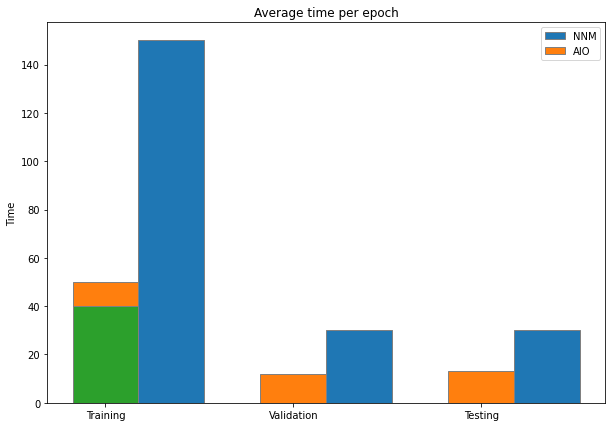

In [29]:
fig = plt.subplots(figsize=(10,7))
width = .35
x_NNM = (np.mean(time_train_NNM),np.mean(time_validation_NNM),np.mean(time_testing_NNM))
x_AIO1 = (np.mean(time_train_AIO),np.mean(time_validation_AIO),np.mean(time_testing_AIO))
x_AIO2 = (np.mean(time_createModel_AIO),0,0)
y1 = np.arange(3)
y2 = [x + width for x in y1]
p1 = plt.bar(y2, x_NNM, width, edgecolor ='grey')
p2 = plt.bar(y1, x_AIO1, width, edgecolor ='grey')
p3 = plt.bar(y1, x_AIO2, width, edgecolor ='grey')

plt.ylabel('Time')
plt.title('Average time per epoch')
plt.xticks(y1, ('Training', 'Validation', 'Testing'))
plt.legend((p1[0], p2[0]), ('NNM', 'AIO'))
plt.show()

<ErrorbarContainer object of 3 artists>

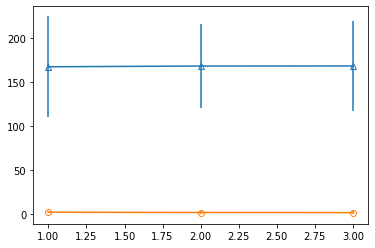

In [55]:
fig = plt.subplots(figsize=(10,7))
x_mean_NNM = np.mean(accu_test_MAE_S11_NNM)
x_std_NNM = np.mean(accu_test_MAE_S11_NNM)
x_mean_AIO = np.mean(accu_test_MAE_S11_AIO)
x_std_AIO = np.mean(accu_test_MAE_S11_AIO)
epoch=[1.0,2.0,3.0]
plt.errorbar(epoch, x_mean_NNM,x_std_NNM,marker='^', markerfacecolor='None')
plt.errorbar(epoch,x_mean_AIO,x_std_AIO, marker='o', markerfacecolor='None')

plt.ylabel('MAE Eror')
plt.ylabel('Epoch Number')
plt.title('MAE comparision')
plt.legend((p1[0], p2[0]), ('NNM', 'AIO'))
plt.show()
plt.show()